# Federated Learning

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kernel import Kernel

from onlineKernels.klmsRFF import *
from onlineKernels.knlmsRFF import *
from onlineKernels.krlsRFF import *

from klms import *

from fl_sync import fl_sync
from fl_async import fl_async
from cent_learn import cent_learn
# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [2]:
def generate_data(num_data):
    # AWGN

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + 0.1*np.random.normal(1), d_true[1] + 0.1*np.random.normal(1)]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + 0.1*np.random.normal(1))

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u),np.array(d),np.array(d_true)

# Parameters
num_data = 3000
kernel = Kernel(3.73)

step_size = 0.8
reg_coeff = 0.1
threshold = 0.5
u,d,d_true = generate_data(num_data)

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


(0.0, 3000.0)

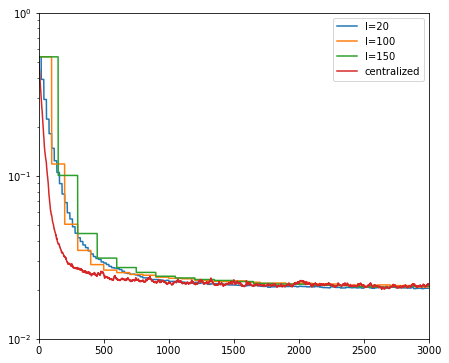

In [14]:
# Federated learning: Synchronous updating rule
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 50 # Dictionary size
L = [20, 100, 150]
iteration = 10000
num_experiments = 10

step_size = 0.8
KLMS_RFF = klms_rff(step_size,D)
# KLMS_RFF = KLMS(u,d,kernel,step_size,threshold,alpha_0=np.array(0).reshape(1,1))
KLMS_RFF_cent = klms_rff(0.2,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for l in L:
    amse = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = generate_data(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
        
        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        mse = fl_sync(iteration,K,KLMS_RFF,h,u,d,l)
        amse += mse/num_experiments

    plt.semilogy(range(len(amse)),amse,label="l=" + str(l))
plt.semilogy(range(len(amse_cent)),amse_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,3000])

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


(0.0, 5000.0)

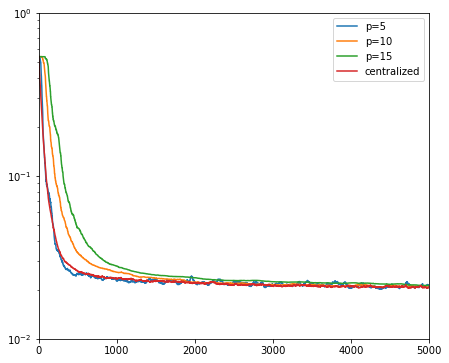

In [10]:
# Federated learning: Asynchronous updating rule
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 50 # Dictionary size
P = [5,10,15]
iteration = 10000
num_experiments = 10

step_size = 0.6
KLMS_RFF = klms_rff(step_size,D)
KLMS_RFF_cent = klms_rff(0.1,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for p in P:
    amse = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,_ = generate_data(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
        
        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        
        mse = fl_async(iteration,K,KLMS_RFF,h,u,d,p)
        amse += mse/num_experiments

    plt.semilogy(range(len(amse)),amse,label="p=" + str(p))
plt.semilogy(range(len(amse_cent)),amse_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e0])
plt.xlim([0,5000])

100%|███████████████████████████████████████████| 10/10 [00:49<00:00,  4.93s/it]


(0.01, 1.0)

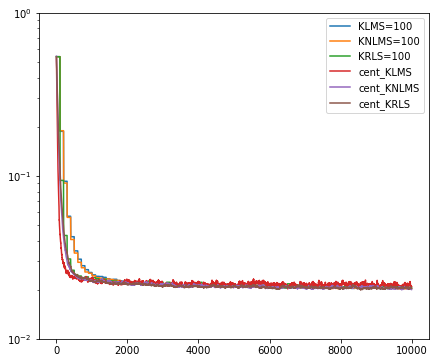

In [20]:
# Synchronous Federated learning using different kernels
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 50 # Dictionary size
L = [100]
iteration = 10000
num_experiments = 10

step_size = 0.5
KLMS_RFF_cent = klms_rff(0.2,D)
KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,0.001,D)
KNLMS_RFF_cent = knlms_rff(0.2,1,D)
KRLS_RFF = krls_rff(D,beta=0.001)
KRLS_RFF_cent = krls_rff(D,beta=10)
for l in L:
    amse_KLMS = np.zeros(iteration)
    amse_KNLMS = np.zeros(iteration)  
    amse_KRLS = np.zeros(iteration)  
    amse_KLMS_cent = np.zeros(iteration)
    amse_KNLMS_cent = np.zeros(iteration)  
    amse_KRLS_cent = np.zeros(iteration)    

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = generate_data(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        mse_KLMS_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_KLMS_cent += mse_KLMS_cent/num_experiments
        mse_KNLMS_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_KNLMS_cent += mse_KNLMS_cent/num_experiments
        mse_KRLS_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_KRLS_cent += mse_KRLS_cent/num_experiments
        
        mse_KLMS = fl_sync(iteration,K,KLMS_RFF,h,u,d,l)
        amse_KLMS += mse_KLMS/num_experiments
        mse_KNLMS = fl_sync(iteration,K,KNLMS_RFF,h,u,d,l)
        amse_KNLMS += mse_KNLMS/num_experiments        
        mse_KRLS = fl_sync(iteration,K,KRLS_RFF,h,u,d,l)
        amse_KRLS += mse_KRLS/num_experiments  
        
plt.semilogy(range(len(amse_KLMS)),amse_KLMS,label="KLMS=" + str(l))
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS,label="KNLMS=" + str(l))
plt.semilogy(range(len(amse_KRLS)),amse_KRLS,label="KRLS=" + str(l))
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="cent_KLMS")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="cent_KNLMS")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="cent_KRLS")
plt.legend()
plt.ylim([1e-2,1e0])
# plt.xlim([0,5000])

100%|███████████████████████████████████████████| 10/10 [00:52<00:00,  5.26s/it]


(0.01, 1.0)

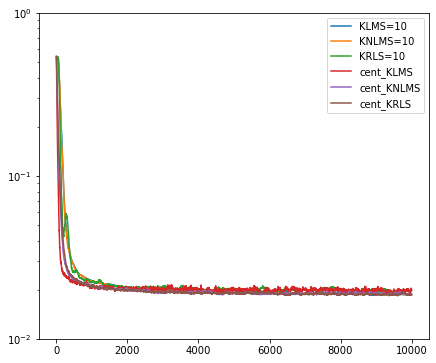

In [21]:
# Asynchronous Federated learning using different kernels
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 50 # Dictionary size
P = [10]
iteration = 10000
num_experiments = 10

step_size = 0.5
KLMS_RFF_cent = klms_rff(0.2,D)
KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,0.001,D)
KNLMS_RFF_cent = knlms_rff(0.2,1,D)
KRLS_RFF = krls_rff(D,beta=0.001)
KRLS_RFF_cent = krls_rff(D,beta=10)

for p in P:
    amse_KLMS = np.zeros(iteration)
    amse_KNLMS = np.zeros(iteration)  
    amse_KRLS = np.zeros(iteration)  
    amse_KLMS_cent = np.zeros(iteration)
    amse_KNLMS_cent = np.zeros(iteration)  
    amse_KRLS_cent = np.zeros(iteration)    

    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        u,d,d_true = generate_data(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(2,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        mse_KLMS_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_KLMS_cent += mse_KLMS_cent/num_experiments
        mse_KNLMS_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_KNLMS_cent += mse_KNLMS_cent/num_experiments
        mse_KRLS_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_KRLS_cent += mse_KRLS_cent/num_experiments
        
        mse_KLMS = fl_async(iteration,K,KLMS_RFF,h,u,d,p)
        amse_KLMS += mse_KLMS/num_experiments
        mse_KNLMS = fl_async(iteration,K,KNLMS_RFF,h,u,d,p)
        amse_KNLMS += mse_KNLMS/num_experiments        
        mse_KRLS = fl_async(iteration,K,KRLS_RFF,h,u,d,p)
        amse_KRLS += mse_KRLS/num_experiments  
        
plt.semilogy(range(len(amse_KLMS)),amse_KLMS,label="KLMS=" + str(p))
plt.semilogy(range(len(amse_KNLMS)),amse_KNLMS,label="KNLMS=" + str(p))
plt.semilogy(range(len(amse_KRLS)),amse_KRLS,label="KRLS=" + str(p))
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="cent_KLMS")
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="cent_KNLMS")
plt.semilogy(range(len(amse_KRLS_cent)),amse_KRLS_cent,label="cent_KRLS")
plt.legend()
plt.ylim([1e-2,1e0])
# plt.xlim([0,5000])

In [41]:
# Asynchronous Federated learning using different kernels

0.013334983005437041